In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Parameters
data_dir = '/content/drive/MyDrive/Dataset'
image_size = (128,128)
batch_size = 32
num_classes = len(os.listdir(data_dir))  # assuming one subdirectory per class
epochs = 20
# Calculate steps per epoch
train_steps = len(train_imgs) // batch_size
val_steps = len(val_imgs) // batch_size
test_steps = len(test_imgs) // batch_size

In [ ]:
# Split dataset into training, validation, and test sets
def split_dataset(data_dir, test_size=0.2, val_size=0.25):
    all_images = []
    all_labels = []
    class_names = os.listdir(data_dir)
    class_indices = {class_name: i for i, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            all_images.append(img_path)
            all_labels.append(class_indices[class_name])

    train_imgs, test_imgs, train_labels, test_labels = train_test_split(
        all_images, all_labels, test_size=test_size, stratify=all_labels)
    train_imgs, val_imgs, train_labels, val_labels = train_test_split(
        train_imgs, train_labels, test_size=val_size, stratify=train_labels)

    return (train_imgs, train_labels), (val_imgs, val_labels), (test_imgs, test_labels), class_names

(train_imgs, train_labels), (val_imgs, val_labels), (test_imgs, test_labels), class_names = split_dataset(data_dir)


In [ ]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)


In [ ]:
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
def generate_data(generator, image_paths, labels, batch_size, class_names):
    while True:
        indices = np.arange(len(image_paths))
        np.random.shuffle(indices)
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            batch_indices = indices[start:end]
            batch_images = [tf.keras.preprocessing.image.load_img(image_paths[i], target_size=image_size) for i in batch_indices]
            batch_images = [tf.keras.preprocessing.image.img_to_array(img) for img in batch_images]
            batch_images = np.array(batch_images)
            batch_images = generator.standardize(batch_images)
            batch_labels = np.array([labels[i] for i in batch_indices])
            yield batch_images, tf.keras.utils.to_categorical(batch_labels, num_classes)

train_generator = generate_data(train_datagen, train_imgs, train_labels, batch_size, class_names)
val_generator = generate_data(val_test_datagen, val_imgs, val_labels, batch_size, class_names)
test_generator = generate_data(val_test_datagen, test_imgs, test_labels, batch_size, class_names)



In [ ]:
# Load the pre-trained FaceNet model
base_model = tf.keras.applications.InceptionResNetV2(include_top=False, input_shape=(160, 160, 3), weights='imagenet')

219055592/219055592 [==============================] - 1s 0us/step


In [ ]:
# Customizing the FaceNet model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)  # Added Batch Normalization
x = Dropout(0.5)(x)  # Added Dropout

# Additional layer for complexity
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)  # Added Batch Normalization
x = Dropout(0.5)(x)  # Added Dropout

In [ ]:
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[:100]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history_finetune = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=val_generator, validation_steps=val_steps, epochs=epochs)


Epoch 1/20
24/24 [==============================] - 507s 21s/step - loss: 3.0085 - accuracy: 0.1589 - val_loss: 2.3162 - val_accuracy: 0.1484
Epoch 2/20
24/24 [==============================] - 224s 10s/step - loss: 2.4924 - accuracy: 0.2832 - val_loss: 1.8701 - val_accuracy: 0.2933
Epoch 3/20
24/24 [==============================] - 229s 10s/step - loss: 1.9824 - accuracy: 0.3631 - val_loss: 1.5205 - val_accuracy: 0.4267
Epoch 4/20
24/24 [==============================] - 224s 9s/step - loss: 1.6997 - accuracy: 0.4621 - val_loss: 1.1439 - val_accuracy: 0.6756
Epoch 5/20
24/24 [==============================] - 227s 9s/step - loss: 1.5084 - accuracy: 0.5407 - val_loss: 1.0005 - val_accuracy: 0.7378
Epoch 6/20
24/24 [==============================] - 227s 9s/step - loss: 1.4179 - accuracy: 0.5528 - val_loss: 0.8720 - val_accuracy: 0.7467
Epoch 7/20
24/24 [==============================] - 223s 9s/step - loss: 1.3662 - accuracy: 0.5664 - val_loss: 0.7511 - val_accuracy: 0.7600
Epoch 8/20

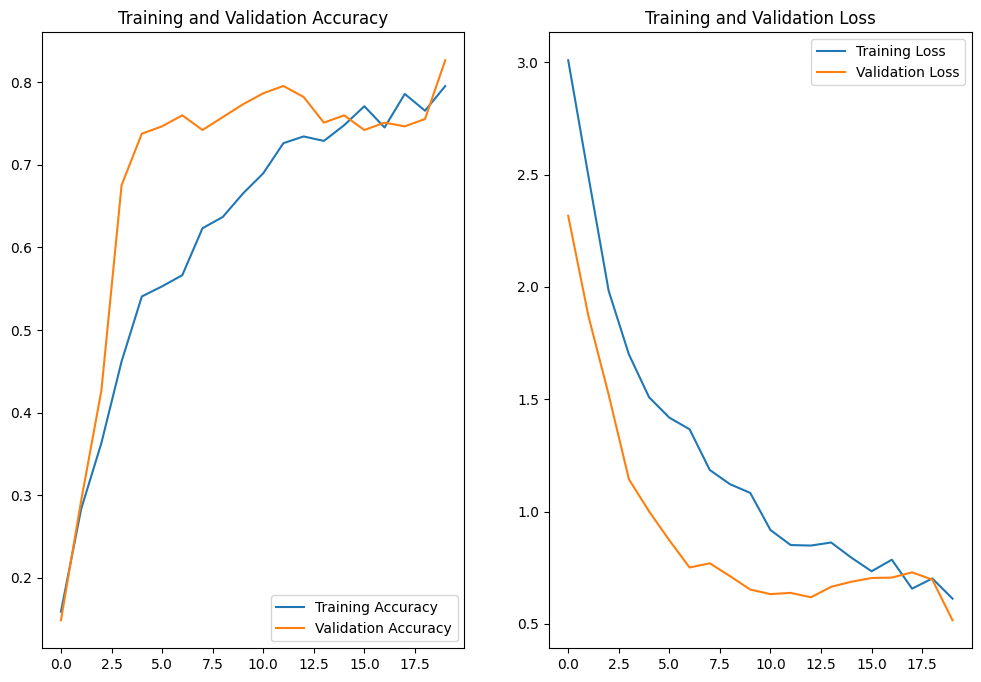

In [ ]:
# Plot accuracy and loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history_finetune)



In [ ]:
# Evaluate the model
test_steps = len(test_imgs) // batch_size
test_loss, test_acc = model.evaluate(test_generator, steps=test_steps)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

# Predict and compute confusion matrix
y_true = test_labels[:test_steps * batch_size]
y_pred = model.predict(test_generator, steps=test_steps)
y_pred_classes = np.argmax(y_pred, axis=1)
# Ensure y_true matches the number of predictions
y_true = y_true[:len(y_pred_classes)]


cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Save the model
model.save('facenet_infrared_model_customized.h5')

NameError: name 'test_imgs' is not defined

219055592/219055592 [==============================] - 2s 0us/step
Epoch 1/5
24/24 [==============================] - 322s 13s/step - loss: 2.6095 - accuracy: 0.2253 - val_loss: 1.7595 - val_accuracy: 0.3477
Epoch 2/5
24/24 [==============================] - 197s 9s/step - loss: 2.2185 - accuracy: 0.3130 - val_loss: 1.5697 - val_accuracy: 0.3867
Epoch 3/5
24/24 [==============================] - 204s 9s/step - loss: 1.8354 - accuracy: 0.4241 - val_loss: 1.3024 - val_accuracy: 0.5156
Epoch 4/5
24/24 [==============================] - 195s 8s/step - loss: 1.6200 - accuracy: 0.4810 - val_loss: 1.2616 - val_accuracy: 0.5644
Epoch 5/5
24/24 [==============================] - 200s 8s/step - loss: 1.4753 - accuracy: 0.5339 - val_loss: 1.1507 - val_accuracy: 0.6267


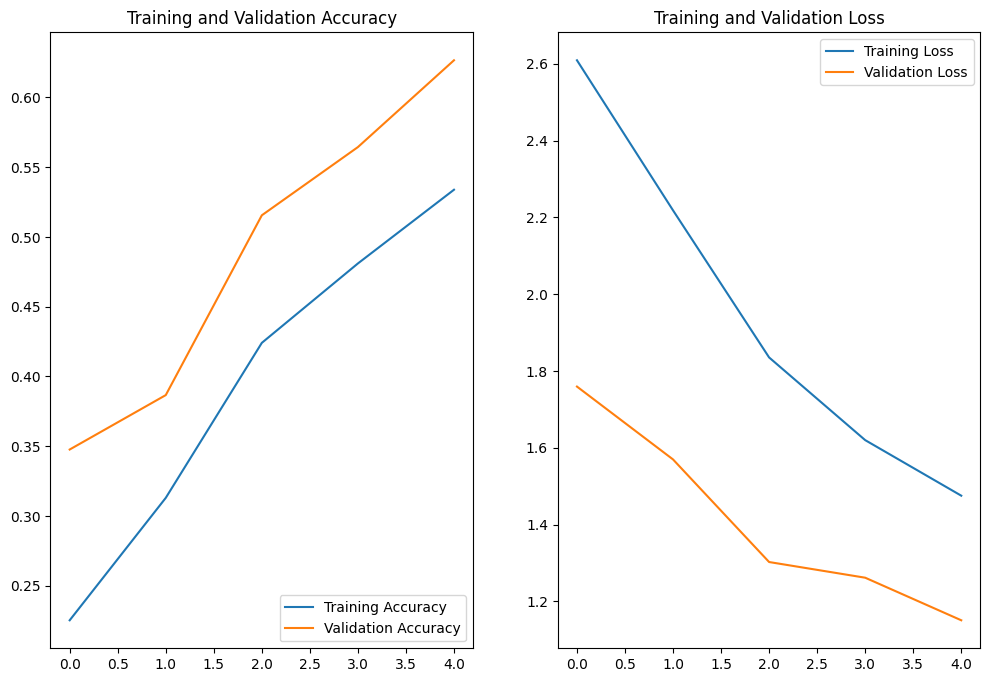

8/8 [==============================] - 62s 9s/step - loss: 1.1494 - accuracy: 0.6836
Test Accuracy: 68.36%
8/8 [==============================] - 18s 2s/step


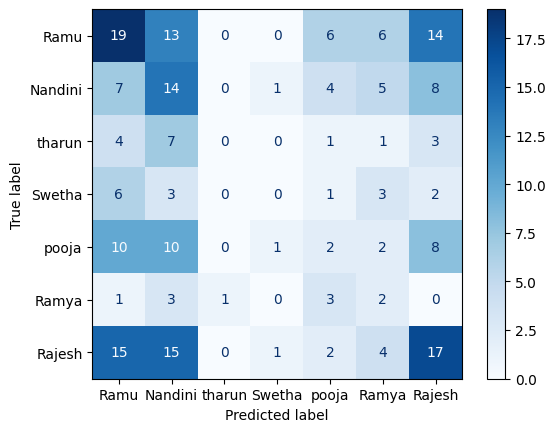

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Correctly Classified Images:


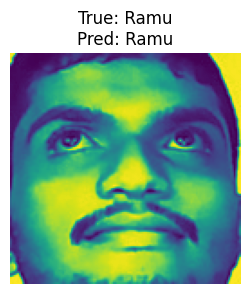

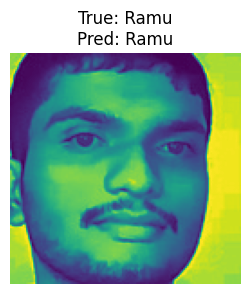

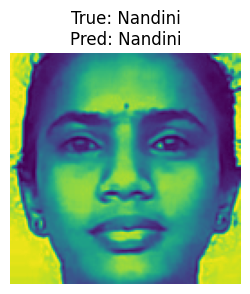

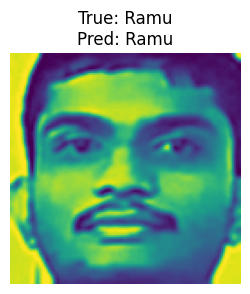

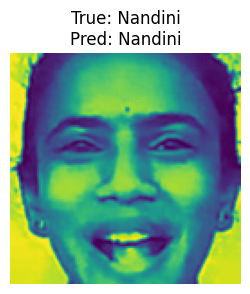


Incorrectly Classified Images:


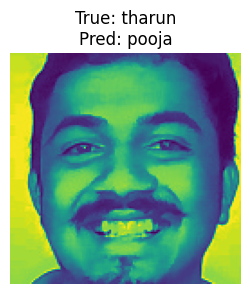

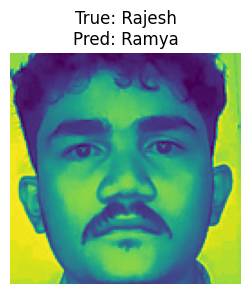

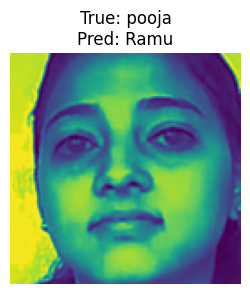

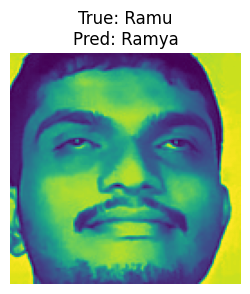

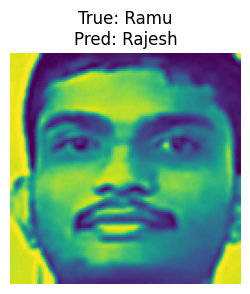

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


# Parameters
data_dir = '/content/drive/MyDrive/Dataset'
image_size = (128,128)
batch_size = 32
num_classes = len(os.listdir(data_dir))  # assuming one subdirectory per class

# Split dataset into training, validation, and test sets
def split_dataset(data_dir, test_size=0.2, val_size=0.25):
    all_images = []
    all_labels = []
    class_names = os.listdir(data_dir)
    class_indices = {class_name: i for i, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            all_images.append(img_path)
            all_labels.append(class_indices[class_name])

    train_imgs, test_imgs, train_labels, test_labels = train_test_split(
        all_images, all_labels, test_size=test_size, stratify=all_labels)
    train_imgs, val_imgs, train_labels, val_labels = train_test_split(
        train_imgs, train_labels, test_size=val_size, stratify=train_labels)

    return (train_imgs, train_labels), (val_imgs, val_labels), (test_imgs, test_labels), class_names

(train_imgs, train_labels), (val_imgs, val_labels), (test_imgs, test_labels), class_names = split_dataset(data_dir)

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)
val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

def generate_data(generator, image_paths, labels, batch_size, class_names):
    while True:
        indices = np.arange(len(image_paths))
        np.random.shuffle(indices)
        for start in range(0, len(image_paths), batch_size):
            end = min(start + batch_size, len(image_paths))
            batch_indices = indices[start:end]
            batch_images = [tf.keras.preprocessing.image.load_img(image_paths[i], target_size=image_size) for i in batch_indices]
            batch_images = [tf.keras.preprocessing.image.img_to_array(img) for img in batch_images]
            batch_images = np.array(batch_images)
            batch_images = generator.standardize(batch_images)
            batch_labels = np.array([labels[i] for i in batch_indices])
            yield batch_images, tf.keras.utils.to_categorical(batch_labels, num_classes)

train_generator = generate_data(train_datagen, train_imgs, train_labels, batch_size, class_names)
val_generator = generate_data(val_test_datagen, val_imgs, val_labels, batch_size, class_names)
test_generator = generate_data(val_test_datagen, test_imgs, test_labels, batch_size, class_names)

# Calculate steps per epoch
train_steps = len(train_imgs) // batch_size
val_steps = len(val_imgs) // batch_size
test_steps = len(test_imgs) // batch_size

# Load the pre-trained FaceNet model
base_model = tf.keras.applications.InceptionResNetV2(include_top=False, input_shape=(160, 160, 3), weights='imagenet')

# Customizing the FaceNet model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)  # Added Batch Normalization
x = Dropout(0.5)(x)  # Added Dropout

# Additional layer for complexity
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)  # Added Batch Normalization
x = Dropout(0.5)(x)  # Added Dropout

predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[:100]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Training with reduced epochs
epochs = 5
history_finetune = model.fit(train_generator, steps_per_epoch=train_steps, validation_data=val_generator, validation_steps=val_steps, epochs=epochs)

# Plot accuracy and loss
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history_finetune)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, steps=test_steps)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

# Predict and compute confusion matrix
y_true = test_labels[:test_steps * batch_size]
y_pred = model.predict(test_generator, steps=test_steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure y_true matches the number of predictions
y_true = y_true[:len(y_pred_classes)]

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Save the model
model.save('facenet_infrared_model_customized.h5')

# Display correctly and incorrectly classified images
def display_classification_results(image_paths, true_labels, pred_labels, class_names, num_images=5):
    correct_indices = np.where(true_labels == pred_labels)[0]
    incorrect_indices = np.where(true_labels != pred_labels)[0]

    print("\nCorrectly Classified Images:")
    for i, idx in enumerate(correct_indices[:num_images]):
        img = plt.imread(image_paths[idx])
        plt.figure(figsize=(3, 3))
        plt.imshow(img)
        plt.title(f"True: {class_names[true_labels[idx]]}\nPred: {class_names[pred_labels[idx]]}")
        plt.axis('off')
        plt.show()

    print("\nIncorrectly Classified Images:")
    for i, idx in enumerate(incorrect_indices[:num_images]):
        img = plt.imread(image_paths[idx])
        plt.figure(figsize=(3, 3))
        plt.imshow(img)
        plt.title(f"True: {class_names[true_labels[idx]]}\nPred: {class_names[pred_labels[idx]]}")
        plt.axis('off')
        plt.show()

display_classification_results(test_imgs, y_true, y_pred_classes, class_names)




Correctly Classified Images:


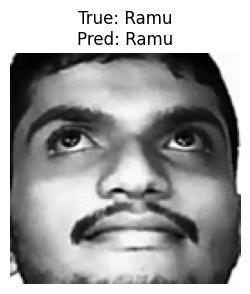

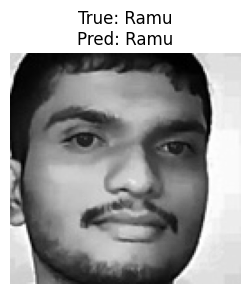

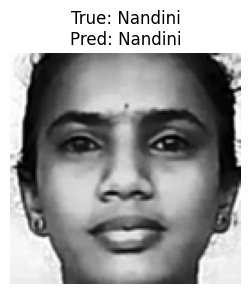

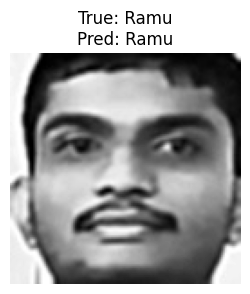

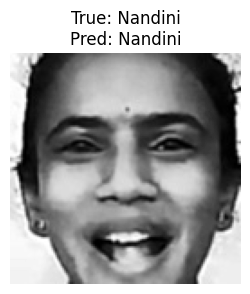


Incorrectly Classified Images:


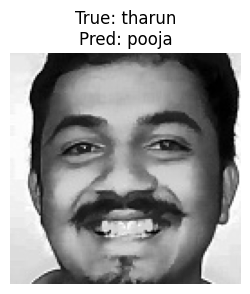

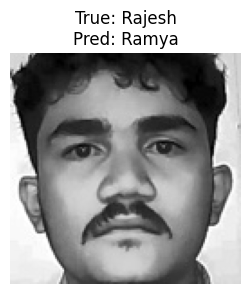

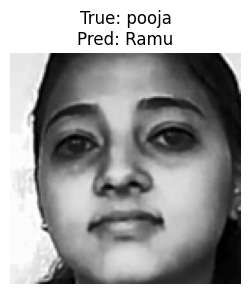

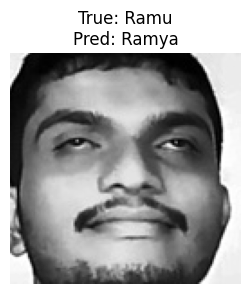

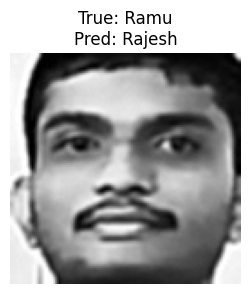

In [ ]:
def display_classification_results(image_paths, true_labels, pred_labels, class_names, num_images=5):
    correct_indices = np.where(true_labels == pred_labels)[0]
    incorrect_indices = np.where(true_labels != pred_labels)[0]

    print("\nCorrectly Classified Images:")
    for i, idx in enumerate(correct_indices[:num_images]):
        img = plt.imread(image_paths[idx])
        plt.figure(figsize=(3, 3))
        plt.imshow(img, cmap='gray')  # Display as grayscale for infrared
        plt.title(f"True: {class_names[true_labels[idx]]}\nPred: {class_names[pred_labels[idx]]}")
        plt.axis('off')
        plt.show()

    print("\nIncorrectly Classified Images:")
    for i, idx in enumerate(incorrect_indices[:num_images]):
        img = plt.imread(image_paths[idx])
        plt.figure(figsize=(3, 3))
        plt.imshow(img, cmap='gray')  # Display as grayscale for infrared
        plt.title(f"True: {class_names[true_labels[idx]]}\nPred: {class_names[pred_labels[idx]]}")
        plt.axis('off')
        plt.show(
display_classification_results(test_imgs, y_true, y_pred_classes, class_names)



Correctly Classified Images:


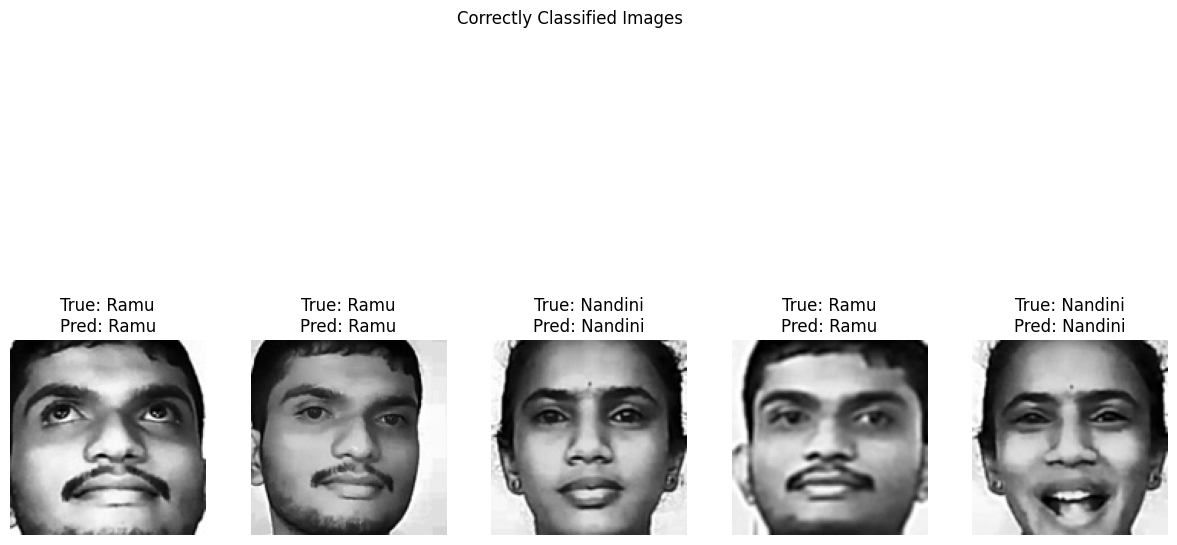


Incorrectly Classified Images:


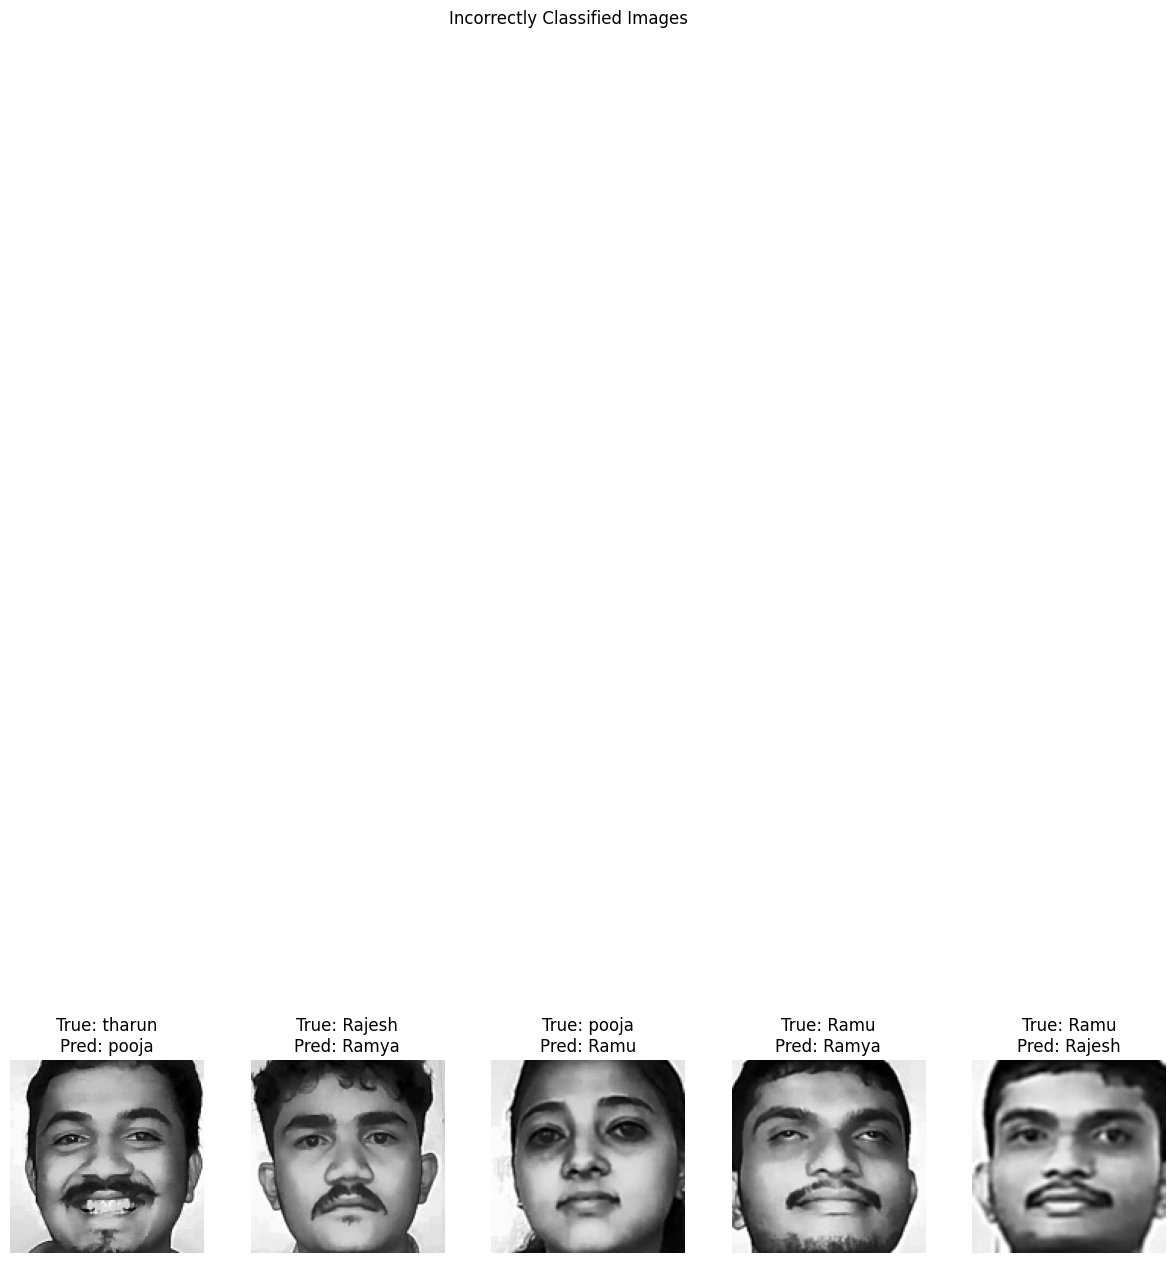

In [ ]:
def display_classification_results(image_paths, true_labels, pred_labels, class_names, num_images=5):
    correct_indices = np.where(true_labels == pred_labels)[0]
    incorrect_indices = np.where(true_labels != pred_labels)[0]

    def plot_images(indices, title):
        num_columns = 5
        num_rows = (len(indices) + num_columns - 1) // num_columns  # Calculate the number of rows needed

        plt.figure(figsize=(15, num_rows * 3))
        for i, idx in enumerate(indices[:num_images]):
            plt.subplot(num_rows, num_columns, i + 1)
            img = plt.imread(image_paths[idx])
            plt.imshow(img, cmap='gray')  # Display as grayscale for infrared
            plt.title(f"True: {class_names[true_labels[idx]]}\nPred: {class_names[pred_labels[idx]]}")
            plt.axis('off')
        plt.suptitle(title)
        plt.show()

    print("\nCorrectly Classified Images:")
    plot_images(correct_indices, "Correctly Classified Images")

    print("\nIncorrectly Classified Images:")
    plot_images(incorrect_indices, "Incorrectly Classified Images")

display_classification_results(test_imgs, y_true, y_pred_classes, class_names)
